# Schelling segregation model 3D

In [1]:
using Pkg, Revise
Pkg.activate(joinpath(@__DIR__, "../.."))
using EasyABM

  Activating project at `~/Documents/EasyABM`


WebIO._IJuliaInit()

## Step 1: Create Agents and Model

Lets create 200 agents with properties `pos`, `mood` and `color`. The `keeps_record_of` argument is list of properties that the agent will record during time evolution. The `min_alike` property of the model which specifies the minimum number of alike neighbors for an agent to be happy, is set to be 8. 

In [2]:
@enum agentsfeeling happy sad

In [3]:
@enum agentsfeeling happy sad
agents = grid_3d_agents(200, pos = Vect(1,1,1), 
    color = cl"red", mood = happy, keeps_record_of=Set([:pos, :mood]))
model = create_3d_model(agents, agents_type = Static, 
    space_type = NPeriodic, size = (7,7,7), min_alike = 8)

EasyABM SpaceModel3D{EasyABM.StaticType, Int64, EasyABM.NPeriodicType}: In a EasyABM.StaticType model number of agents is fixed.



## Step 2: Initialise the model

In the second step we initialise the agents by defining `initialiser!` function and then sending it as an argument to `init_model!`. In the `initialiser!` function we randomly set agents color to be either `cl"red"` or `cl"green"` and set their positions randomly such that there is not more than one agent on each patch. Then we set the `mood` property of each agent to be `happy` or `sad` depending upon the number of alike agents in neighborhood. 

In [4]:
function initialiser!(model)
    for agent in model.agents
        agent.color = [cl"red", cl"green"][rand(1:2)]
        x,y,z = random_empty_patch(model) 
        agent.pos = Vect(x, y, z)     
    end    
    for agent in model.agents
        nbrs = neighbors_moore(agent, model, 1)
        num_same = 0
        for nbr in nbrs
            if nbr.color == agent.color
                num_same += 1
            end
        end
        if num_same < model.properties.min_alike
            agent.mood = sad
        end
    end
end
init_model!(model, initialiser = initialiser!)


## Step 3: Defining the step_rule! and running the model

In this step we implement the step logic of the Schellings model in the `step_rule!` function and run the model for 100 steps. 

In [5]:
function step_rule!(model)
    min_alike = model.properties.min_alike
    for agent in model.agents
        num_alike = 0
        for nbr in neighbors_moore(agent, model,1)
            if agent.color == nbr.color
                num_alike += 1
            end
        end
        if num_alike ≥ min_alike
            agent.mood = happy
        else
            agent.mood = sad
            x,y,z = random_empty_patch(model) 
            agent.pos = Vect(x, y, z)
        end
    end
    return
end

step_rule! (generic function with 1 method)

In [6]:
run_model!(model, steps=100, step_rule = step_rule!)

## Step 4: Visualisation

The following code will draw the state of the model at frame number 4. 

In [7]:
draw_frame(model, frame=4)

[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0xa8, 0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("agents" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31], Dict{String, Vector{UInt8}}("position" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x74, 0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "54" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x35, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x35, 0x34], Dict{String, Vector{UInt8}}("position" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x35, 0x34]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "101" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31, 0x30, 0x31], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31, 0x30, 0x31], Dict{String, Vector{UInt8}}("position" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31, 0x30, 0x31]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "41" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x34, 0x31], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x34, 0x31], Dict{String, Vector{UInt8}}("position" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x34, 0x31]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "65" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x36, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x36, 0x35], Dict{String, Vector{UInt8}}("position" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x2f, 0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x36, 0x35]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "168" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31, 0x36, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31, 0x36, 0x38], Dict{String, Vector{UInt8}}("position" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31, 0x36, 0x38]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "159" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31, 0x35, 0x39], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x67, 0x65, 0x6e, 0x74, 0x73, 0x2f, 0x31, 0

If one wants to see the animation of the model run, it can be done as 

In [8]:
animate_sim(model, 20, agent_plots = Dict(
        "happy"=> ag -> ag.mood == happy ? 1 : 0
        ))

[ Info: Listening on: 127.0.0.1:8701, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8701


WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 20, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(10), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007fa094ae5aa0, Task (runnable) @0x00007fa094ae5aa0), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 140327696461936, 0)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\

After defining the `step_rule!` function we can also choose to create an interactive application (which currently works in Jupyter with WebIO installation) as 

In [9]:
create_interactive_app(model, initialiser= initialiser!,
    step_rule=step_rule!,
    model_controls=[(:min_alike, "slider", 1:12)], 
    agent_plots=Dict(
        "happy"=> agent-> agent.mood == happy, 
        "sad"=> agent-> agent.mood == sad),
    frames=200)   

[ Info: Listening on: 127.0.0.1:8702, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8702


WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 200, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(1), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007fa06157cc90, Task (runnable) @0x00007fa06157cc90), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (2, 140325849864896, 140325843086352)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n 

## Step 5: Fetch Data 

In this step we fetch data of number of happy and sad agents at each time step as a dataframe with following function. 

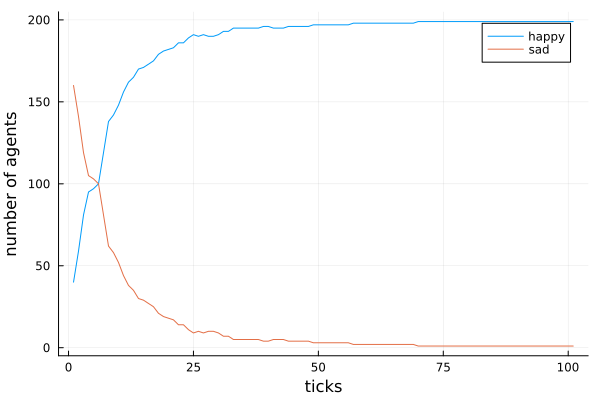

Row,happy,sad
,Int64,Int64
1,40,160
2,59,141
3,81,119
4,95,105
5,97,103
6,100,100
7,119,81
8,138,62
9,142,58


In [10]:
df = get_nums_agents(model, 
    agent-> agent.mood == happy, 
    agent-> agent.mood == sad,
    labels=["happy","sad"], plot_result=true)

Individual agent data recorded during model run can be obtained as 

In [11]:
df = get_agent_data(model.agents[1], model).record

Row,mood,pos
,agentsfe…,Vect…
1,happy,"(4, 5, 3)\n"
2,happy,"(4, 5, 3)\n"
3,sad,"(3, 5, 1)\n"
4,sad,"(6, 6, 2)\n"
5,happy,"(6, 6, 2)\n"
6,happy,"(6, 6, 2)\n"
7,sad,"(2, 1, 1)\n"
8,sad,"(3, 7, 3)\n"
9,sad,"(1, 3, 5)\n"
